## kNN TIP Improved Teachers

In [1]:
#import some libraries

import pyodbc
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
from sqlalchemy import create_engine, MetaData, Table, select
import seaborn as sns
import sklearn
import nltk
from nltk import word_tokenize
# nltk.download()
#import rpy2
import spacy
import en_core_web_sm  # or any other model you downloaded via spacy download or pip
nlp = en_core_web_sm.load()
#import gensim

# load the R package ISLR
# infert = com.importr("ISLR")

# Enable inline plotting
%matplotlib inline

#Import and assign WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [2]:
#get some version info
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('NLTK version ' + nltk.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
Pandas version 0.20.3
NLTK version 3.2.4
Matplotlib version 2.0.2


### Use Windows Authentication to connect to SQL Server
#### Assign database=master to make sure we can connect to both ORD_INT and APPR_EXT

In [3]:
# assign server and db
server = 'ES11vADOSQL006'
db = 'master'

# Create the connection to all dbs
cnxn = pyodbc.connect('DRIVER={ODBC Driver 11 for SQL Server};SERVER=ES11vADOSQL006;DATABASE=master;Trusted_Connection=yes;')
# Connect to ORD_INT
#ORD_INT = pyodbc.connect('DRIVER={ODBC Driver 11 for SQL Server};SERVER=ES11vADOSQL006;DATABASE=ORD_INT;Trusted_Connection=yes;')

#### Create initial dataset by joining APPRTIP (teacher level TIP data, including text, meeting dates, etc) with TRD_APPR_Ratings_v (Reliable year over year Advance ratings at the teacher level)
#### Exclude teachers who are not Advance eligible, as well as those whose TIP ended due to an appeal and those which were never submitted through AWA

#### Calculate the number of calendar days between TIP meetings as recorded in AWA
#### Calculate word counts for each TIP section by dividing the total character count by 6.04 --> avg word length plus 1.25 for punctuation and spaces

In [159]:
# join APPRTIP and TRD_APPR_Ratings_v
# calculate word counts for 5 TIP sections
# calculate days between each TIP meeting
sql3 = """

SELECT a.*
,(datalength(a.TIPImprovementPlan1)/6.04) as IP_wrd_ct
,(datalength(a.TIPActionPlan)/6.04) as ActP_wrd_ct
,(datalength(a.TIPTimeLinePlan)/6.04) as TLP_wrd_ct 
,(datalength(a.TIPSupportPlan)/6.04) as SP_wrd_ct
,(datalength(a.TIPAssessmentPlan)/6.04) as AsmtP_wrd_ct 
,(datalength(a.TIPImprovementPlan1+a.TIPActionPlan+a.TIPTimeLinePlan+a.TIPSupportPlan+a.TIPAssessmentPlan)/6.04) as total_wrd_ct
,(a.TIPImprovementPlan1 + ' ' + a.TIPActionPlan + ' ' + a.TIPTimeLinePlan + ' ' + a.TIPSupportPlan + ' ' + a.TIPAssessmentPlan) as TIP_all_txt
,b.Last_Name
    ,b.First_Name
    ,b.Rating_DBN
    ,b.MOTP_Points
    ,b.MOTP_Rating
    ,b.MOSL_Points_Local
    ,b.MOSL_Rating_Local
      ,b.MOSL_Points_State
      ,b.MOSL_Rating_State 
      ,b.Overall_Points
      ,b.Overall_Rating
      ,b.TIPRating
      ,(DATEDIFF(dd, a.TIPMeeting1,a.TIPMeeting2)) AS days_bt_mt1_mt2
      ,(DATEDIFF(dd, a.TIPMeeting2,a.TIPMeeting3)) AS days_bt_mt2_mt3
      ,(DATEDIFF(dd, a.TIPMeeting3,a.TIPMeeting4)) AS days_bt_mt3_mt4
      ,(DATEDIFF(dd, a.TIPMeeting4,a.TIPMeeting5)) AS days_bt_mt4_mt5
FROM [APPR_EXT].[dbo].[APPRTIP] as a inner join [ORD_INT].[dbo].[TRD_APPR_Ratings_v] as b
on a.Employeeid = b.Employeeid AND a.FiscalYear = b.FiscalYear
where a.IsSubmitted = 'Y' and a.TIPEndedAppeal = 'N' and b.Advance_Eligibility_Status = 'Y' and TIPRating in ('Effective', 'Highly Effective')

"""
TIP_with_rats = pd.io.sql.read_sql(sql3, cnxn)
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_Local,MOSL_Points_State,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,,16.0,Effective,NaN,Effective,Effective,209.0,56.0,-121.0,-97.0
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,,16.0,Effective,NaN,Effective,Effective,217.0,58.0,NaN,NaN
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,Effective,NaN,,79.0,Effective,Effective,121.0,154.0,NaN,NaN
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,,16.0,Effective,NaN,Effective,Effective,125.0,142.0,-49.0,21.0
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,Highly Effective,17.0,Effective,79.0,Effective,Effective,146.0,NaN,NaN,NaN


In [160]:
TIP_with_rats = TIP_with_rats.fillna('')

In [161]:
TIP_with_rats['TIP_all_txt'] = TIP_with_rats[['TIPImprovementPlan1', 'TIPImprovementPlan2', 'TIPImprovementPlan3', 'TIPActionPlan', 'TIPTimeLinePlan','TIPSupportPlan', 'TIPAssessmentPlan']].apply(lambda x: ''.join(x), axis=1)
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_Local,MOSL_Points_State,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23 00:00:00,2017-04-20 00:00:00,...,,16,Effective,,Effective,Effective,209,56,-121,-97
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21 00:00:00,2017-04-26 00:00:00,...,,16,Effective,,Effective,Effective,217,58,,
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08 00:00:00,2016-01-07 00:00:00,...,Effective,,,79,Effective,Effective,121,154,,
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20 00:00:00,2017-01-23 00:00:00,...,,16,Effective,,Effective,Effective,125,142,-49,21
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17 00:00:00,2015-02-10 00:00:00,...,Highly Effective,17,Effective,79,Effective,Effective,146,,,


In [162]:
TIP_with_rats['total_TIP_length'] = TIP_with_rats['TIP_all_txt'].apply(lambda x: len(x))
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Points_State,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23 00:00:00,2017-04-20 00:00:00,...,16,Effective,,Effective,Effective,209,56,-121,-97,6641
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21 00:00:00,2017-04-26 00:00:00,...,16,Effective,,Effective,Effective,217,58,,,4739
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08 00:00:00,2016-01-07 00:00:00,...,,,79,Effective,Effective,121,154,,,3865
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20 00:00:00,2017-01-23 00:00:00,...,16,Effective,,Effective,Effective,125,142,-49,21,9084
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17 00:00:00,2015-02-10 00:00:00,...,17,Effective,79,Effective,Effective,146,,,,11853


#### Calculate number of TIP meetings per employee per year

In [163]:
#Get count of meetings by employee_id
TIP_with_rats['meeting_ct'] = TIP_with_rats.filter(regex=r'^TIPMeeting').notnull().sum(axis=1)

#print top 5 rows to see results
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length,meeting_ct
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23 00:00:00,2017-04-20 00:00:00,...,Effective,,Effective,Effective,209,56,-121,-97,6641,5
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21 00:00:00,2017-04-26 00:00:00,...,Effective,,Effective,Effective,217,58,,,4739,5
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08 00:00:00,2016-01-07 00:00:00,...,,79,Effective,Effective,121,154,,,3865,5
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20 00:00:00,2017-01-23 00:00:00,...,Effective,,Effective,Effective,125,142,-49,21,9084,5
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17 00:00:00,2015-02-10 00:00:00,...,Effective,79,Effective,Effective,146,,,,11853,5


In [164]:
#coerce meeting columns to datetime
from datetime import datetime
from datetime import date

cols = TIP_with_rats.columns[TIP_with_rats.columns.str.startswith('TIPMeeting')]
TIP_with_rats[cols] = TIP_with_rats[cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))

#print tip 5 rows to see results
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length,meeting_ct
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,Effective,,Effective,Effective,209,56,-121,-97,6641,5
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,Effective,,Effective,Effective,217,58,,,4739,5
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,,79,Effective,Effective,121,154,,,3865,5
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,Effective,,Effective,Effective,125,142,-49,21,9084,5
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,Effective,79,Effective,Effective,146,,,,11853,5


In [165]:
TIP_with_rats.describe()

,FiscalYear,IP_wrd_ct,ActP_wrd_ct,TLP_wrd_ct,SP_wrd_ct,AsmtP_wrd_ct,total_wrd_ct,total_TIP_length,meeting_ct
count,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.0
mean,2016.121203,115.938842,339.641350,39.702532,118.083593,183.356233,796.722553,4812.204223,5.0
std,0.818069,106.069778,234.574577,70.650985,97.900204,161.207985,443.686798,2679.868261,0.0
min,2015.000000,0.993377,0.165562,0.165562,0.165562,0.165562,8.278145,50.000000,5.0
25%,2015.000000,55.132450,155.132450,13.410596,49.503311,74.172185,480.049668,2899.500000,5.0
50%,2016.000000,91.887417,291.390728,14.072847,97.268212,168.874172,733.940397,4433.000000,5.0
75%,2017.000000,139.693708,473.634105,37.913907,158.278145,221.026490,1035.678807,6255.500000,5.0
max,2017.000000,993.377483,993.377483,990.728476,993.377483,993.377483,3327.649006,20099.000000,5.0


#### Here we create 5 new columns of tokenized text from the original 5 text columns in the TIP dataset

In [166]:
#Set up spaCy
import spacy
import en_core_web_sm  # or any other model you downloaded via spacy download or pip
nlp = en_core_web_sm.load()
from spacy.en import English
parser = English()
from spacy.en.word_sets import STOP_WORDS
from spacy.attrs import ORTH

In [167]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [168]:
from spacy.parts_of_speech import PROPN

def is_proper_noun(token):
    if token.doc.is_tagged is False:  # check if the document was POS-tagged
        raise ValueError('token is not POS-tagged')

    return token.pos == PROPN

##### Get row count for TIP_with_rats['TIPImprovementPlan1']

In [169]:
TIP_with_rats['TIPImprovementPlan1'].count()

6914

### Pull TIPImprovementPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [170]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPImprovementPlan1'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_IP'] = tokens
TIP_with_rats['s_lemmas_IP'] = lemma 
TIP_with_rats['s_pos_IP'] = pos
TIP_with_rats['s_orth_IP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length,meeting_ct,s_tokens_IP,s_lemmas_IP,s_pos_IP,s_orth_IP
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,209,56,-121,-97,6641,5,"[Based, review, completed, feedback, observati...","[base, review, complete, feedback, observation...","[VERB, NOUN, VERB, NOUN, NOUN, VERB, NOUN, NOU...","[7157, 3835, 9164, 5700, 84141, 9457, 887, 362..."
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,217,58,,,4739,5,"[Having, reviewed, year, 's, observations, fee...","[have, review, year, 's, observation, feedback...","[VERB, VERB, NOUN, PART, NOUN, NOUN, NOUN, ADJ...","[3460, 9435, 887, 525, 84141, 5700, 362922, 21..."
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,121,154,,,3865,5,"[Areas, Improvement, specific, areas, need, im...","[area, improvement, specific, area, need, impr...","[NOUN, NOUN, ADJ, NOUN, NOUN, NOUN, NUM, ADJ, ...","[583791, 597198, 1888, 2511, 730, 5779, 928, 3..."
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,125,142,-49,21,9084,5,"[1, Aligning, instructional, outcomes, learnin...","[1, align, instructional, outcome, learn, acti...","[PUNCT, VERB, ADJ, NOUN, VERB, NOUN, NOUN, VER...","[928, 554674, 255181, 129211, 2582, 4906, 4613..."
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,146,,,,11853,5,"[1, Giving, feedback, students, timely, constr...","[1, give, feedback, student, timely, construct...","[PUNCT, VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB,...","[928, 544754, 5700, 2401, 516075, 357305, 5012..."


#### Get row count for TIPActionPlan
#### Pull TIPActionPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [171]:
TIP_with_rats['TIPActionPlan'].count()

6914

In [172]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPActionPlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_AP'] = tokens
TIP_with_rats['s_lemmas_AP'] = lemma 
TIP_with_rats['s_pos_AP'] = pos
TIP_with_rats['s_orth_AP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,total_TIP_length,meeting_ct,s_tokens_IP,s_lemmas_IP,s_pos_IP,s_orth_IP,s_tokens_AP,s_lemmas_AP,s_pos_AP,s_orth_AP
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,6641,5,"[Based, review, completed, feedback, observati...","[base, review, complete, feedback, observation...","[VERB, NOUN, VERB, NOUN, NOUN, VERB, NOUN, NOU...","[7157, 3835, 9164, 5700, 84141, 9457, 887, 362...","[genuine, discussions, variety, questions, des...","[genuine, discussion, variety, question, desig...","[ADJ, NOUN, NOUN, NOUN, VERB, VERB, NOUN, PUNC...","[5216, 6733, 4566, 1640, 2584, 3999, 2401, 928..."
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,4739,5,"[Having, reviewed, year, 's, observations, fee...","[have, review, year, 's, observation, feedback...","[VERB, VERB, NOUN, PART, NOUN, NOUN, NOUN, ADJ...","[3460, 9435, 887, 525, 84141, 5700, 362922, 21...","[1, developing, rigorous, engaging, lessons, a...","[1, develop, rigorous, engaging, lesson, appro...","[PUNCT, VERB, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, ...","[928, 4635, 412318, 8871, 6860, 2908, 4116, 11..."
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,3865,5,"[Areas, Improvement, specific, areas, need, im...","[area, improvement, specific, area, need, impr...","[NOUN, NOUN, ADJ, NOUN, NOUN, NOUN, NUM, ADJ, ...","[583791, 597198, 1888, 2511, 730, 5779, 928, 3...","[1, assessment, data, plan, differentiated, le...","[1, assessment, datum, plan, differentiate, le...","[NUM, NOUN, NOUN, VERB, VERB, NOUN, NOUN, NOUN...","[928, 8944, 1614, 1323, 419134, 2582, 129211, ..."
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,9084,5,"[1, Aligning, instructional, outcomes, learnin...","[1, align, instructional, outcome, learn, acti...","[PUNCT, VERB, ADJ, NOUN, VERB, NOUN, NOUN, VER...","[928, 554674, 255181, 129211, 2582, 4906, 4613...","[1, improvement, alignment, learning, activiti...","[1, improvement, alignment, learn, activity, i...","[NUM, NOUN, NOUN, VERB, NOUN, ADJ, NOUN, NOUN,...","[928, 5779, 245271, 2582, 4906, 255181, 129211..."
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,11853,5,"[1, Giving, feedback, students, timely, constr...","[1, give, feedback, student, timely, construct...","[PUNCT, VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB,...","[928, 544754, 5700, 2401, 516075, 357305, 5012...","[1, Giving, feedback, students, timely, constr...","[1, give, feedback, student, timely, construct...","[PUNCT, VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB,...","[928, 544754, 5700, 2401, 516075, 357305, 5012..."


#### Get row count for TIPTimeLinePlan
#### Pull TIPTimeLinePlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [173]:
TIP_with_rats['TIPTimeLinePlan'].count()

6914

In [174]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPTimeLinePlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.appent(None)

TIP_with_rats['s_tokens_TLP'] = tokens
TIP_with_rats['s_lemmas_TLP'] = lemma
TIP_with_rats['s_pos_TLP'] = pos
TIP_with_rats['s_orth_TLP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_IP,s_orth_IP,s_tokens_AP,s_lemmas_AP,s_pos_AP,s_orth_AP,s_tokens_TLP,s_lemmas_TLP,s_pos_TLP,s_orth_TLP
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,"[VERB, NOUN, VERB, NOUN, NOUN, VERB, NOUN, NOU...","[7157, 3835, 9164, 5700, 84141, 9457, 887, 362...","[genuine, discussions, variety, questions, des...","[genuine, discussion, variety, question, desig...","[ADJ, NOUN, NOUN, NOUN, VERB, VERB, NOUN, PUNC...","[5216, 6733, 4566, 1640, 2584, 3999, 2401, 928...","[week, submit, lesson, plan, examples, student...","[week, submit, lesson, plan, example, student,...","[NOUN, VERB, NOUN, NOUN, NOUN, NOUN, NOUN, VER...","[1391, 3153, 4142, 1323, 2978, 2615, 747, 4635..."
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,"[VERB, VERB, NOUN, PART, NOUN, NOUN, NOUN, ADJ...","[3460, 9435, 887, 525, 84141, 5700, 362922, 21...","[1, developing, rigorous, engaging, lessons, a...","[1, develop, rigorous, engaging, lesson, appro...","[PUNCT, VERB, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, ...","[928, 4635, 412318, 8871, 6860, 2908, 4116, 11...","[Refer, timelines, included, end, action, step...","[refer, timeline, include, end, action, step, ...","[VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[142144, 784215, 3175, 948, 1925, 2066, 3774, ..."
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,"[NOUN, NOUN, ADJ, NOUN, NOUN, NOUN, NUM, ADJ, ...","[583791, 597198, 1888, 2511, 730, 5779, 928, 3...","[1, assessment, data, plan, differentiated, le...","[1, assessment, datum, plan, differentiate, le...","[NUM, NOUN, NOUN, VERB, VERB, NOUN, NOUN, NOUN...","[928, 8944, 1614, 1323, 419134, 2582, 129211, ...","[Refer, timeline, action]","[refer, timeline, action]","[VERB, NOUN, NOUN]","[142144, 463534, 1925]"
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,"[PUNCT, VERB, ADJ, NOUN, VERB, NOUN, NOUN, VER...","[928, 554674, 255181, 129211, 2582, 4906, 4613...","[1, improvement, alignment, learning, activiti...","[1, improvement, alignment, learn, activity, i...","[NUM, NOUN, NOUN, VERB, NOUN, ADJ, NOUN, NOUN,...","[928, 5779, 245271, 2582, 4906, 255181, 129211...","[1, Debrief, peers, occur, professional, devel...","[1, debrief, peer, occur, professional, develo...","[PUNCT, VERB, NOUN, VERB, ADJ, NOUN, VERB, PUN...","[928, 280760, 8239, 4435, 3577, 2502, 6323, 88..."
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,"[PUNCT, VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB,...","[928, 544754, 5700, 2401, 516075, 357305, 5012...","[1, Giving, feedback, students, timely, constr...","[1, give, feedback, student, timely, construct...","[PUNCT, VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB,...","[928, 544754, 5700, 2401

#### Get row count for TIPSupportPlan
#### Pull TIPSupportPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [175]:
TIP_with_rats['TIPSupportPlan'].count()

6914

In [176]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPSupportPlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_SP'] = tokens
TIP_with_rats['s_lemmas_SP'] = lemma
TIP_with_rats['s_pos_SP'] = pos
TIP_with_rats['s_orth_SP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_AP,s_orth_AP,s_tokens_TLP,s_lemmas_TLP,s_pos_TLP,s_orth_TLP,s_tokens_SP,s_lemmas_SP,s_pos_SP,s_orth_SP
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,"[ADJ, NOUN, NOUN, NOUN, VERB, VERB, NOUN, PUNC...","[5216, 6733, 4566, 1640, 2584, 3999, 2401, 928...","[week, submit, lesson, plan, examples, student...","[week, submit, lesson, plan, example, student,...","[NOUN, VERB, NOUN, NOUN, NOUN, NOUN, NOUN, VER...","[1391, 3153, 4142, 1323, 2978, 2615, 747, 4635...","[1, week, submit, lesson, plan, paired, exampl...","[1, week, submit, lesson, plan, pair, example,...","[PUNCT, NOUN, VERB, NOUN, NOUN, VERB, NOUN, NO...","[928, 1391, 3153, 4142, 1323, 27759, 1089, 261..."
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,"[PUNCT, VERB, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, ...","[928, 4635, 412318, 8871, 6860, 2908, 4116, 11...","[Refer, timelines, included, end, action, step...","[refer, timeline, include, end, action, step, ...","[VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[142144, 784215, 3175, 948, 1925, 2066, 3774, ...","[1, Participate, 's, block, focusing, use, ali...","[1, participate, 's, block, focus, use, aligne...","[NUM, VERB, PART, NOUN, VERB, NOUN, ADJ, ADJ, ...","[928, 176353, 525, 3629, 6587, 637, 457422, 35..."
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,"[NUM, NOUN, NOUN, VERB, VERB, NOUN, NOUN, NOUN...","[928, 8944, 1614, 1323, 419134, 2582, 129211, ...","[Refer, timeline, action]","[refer, timeline, action]","[VERB, NOUN, NOUN]","[142144, 463534, 1925]","[weekly, school, wide, professional, planning,...","[weekly, school, wide, professional, planning,...","[ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, NOUN, NOUN, ...","[53291, 1050, 3402, 3577, 3401, 2615, 74451, 1..."
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,"[NUM, NOUN, NOUN, VERB, NOUN, ADJ, NOUN, NOUN,...","[928, 5779, 245271, 2582, 4906, 255181, 129211...","[1, Debrief, peers, occur, professional, devel...","[1, debrief, peer, occur, professional, develo...","[PUNCT, VERB, NOUN, VERB, ADJ, NOUN, VERB, PUN...","[928, 280760, 8239, 4435, 3577, 2502, 6323, 88...","[1, sit, select, PDs, appropriate, growth, mee...","[1, sit, select, pd, appropriate, growth, meet...","[NUM, VERB, VERB, NOUN, VERB, NOUN, NOUN, NUM,...","[928, 2448, 5336, 13460, 2908, 3112, 4027, 597..."
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,"[PUNCT, VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB,...","[928, 544754, 5700, 2401, 516075, 357305, 5012...","[1.Giving, feedback, students, timely, constru...","[1.giv, feedback, student, timely, constructiv...","[VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB, NOUN, ...","[798418, 5700, 2401, 516

#### Get row count for TIPAssessmentPlan
#### Pull TIPAssessmentPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [177]:
TIP_with_rats['TIPAssessmentPlan'].count()

6914

In [178]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPAssessmentPlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_AsmtP'] = tokens
TIP_with_rats['s_lemmas_AsmtP'] = lemma
TIP_with_rats['s_pos_AsmtP'] = pos
TIP_with_rats['s_orth_AsmtP'] = orth


TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_TLP,s_orth_TLP,s_tokens_SP,s_lemmas_SP,s_pos_SP,s_orth_SP,s_tokens_AsmtP,s_lemmas_AsmtP,s_pos_AsmtP,s_orth_AsmtP
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,"[NOUN, VERB, NOUN, NOUN, NOUN, NOUN, NOUN, VER...","[1391, 3153, 4142, 1323, 2978, 2615, 747, 4635...","[1, week, submit, lesson, plan, paired, exampl...","[1, week, submit, lesson, plan, pair, example,...","[PUNCT, NOUN, VERB, NOUN, NOUN, VERB, NOUN, NO...","[928, 1391, 3153, 4142, 1323, 27759, 1089, 261...","[improvement, assessed, based, reflecting, obs...","[improvement, assess, base, reflect, observati...","[NOUN, VERB, VERB, VERB, NOUN, NOUN, NOUN, NOU...","[5779, 341296, 1090, 11448, 84141, 5700, 2511,..."
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,"[VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[142144, 784215, 3175, 948, 1925, 2066, 3774, ...","[1, Participate, 's, block, focusing, use, ali...","[1, participate, 's, block, focus, use, aligne...","[NUM, VERB, PART, NOUN, VERB, NOUN, ADJ, ADJ, ...","[928, 176353, 525, 3629, 6587, 637, 457422, 35...","[second, subsequent, meetings, review, evidenc...","[second, subsequent, meeting, review, evidence...","[ADJ, ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN,...","[1234, 9446, 7341, 3835, 1282, 13765, 84141, 2..."
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,"[VERB, NOUN, NOUN]","[142144, 463534, 1925]","[weekly, school, wide, professional, planning,...","[weekly, school, wide, professional, planning,...","[ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, NOUN, NOUN, ...","[53291, 1050, 3402, 3577, 3401, 2615, 74451, 1...","[second, meeting, review, evidence, classroom,...","[second, meeting, review, evidence, classroom,...","[ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB...","[1234, 4027, 3835, 1282, 13765, 84141, 2401, 7..."
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,"[PUNCT, VERB, NOUN, VERB, ADJ, NOUN, VERB, PUN...","[928, 280760, 8239, 4435, 3577, 2502, 6323, 88...","[1, sit, select, PDs, appropriate, growth, mee...","[1, sit, select, pd, appropriate, growth, meet...","[NUM, VERB, VERB, NOUN, VERB, NOUN, NOUN, NUM,...","[928, 2448, 5336, 13460, 2908, 3112, 4027, 597...","[monthly, meetings, review, evidence, classroo...","[monthly, meeting, review, evidence, classroom...","[ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, NOUN...","[7002, 7341, 3835, 1282, 13765, 84141, 2615, 7..."
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,"[VERB, NOUN, NOUN, ADJ, ADJ, ADJ, VERB, NOUN, ...","[798418, 5700, 2401, 516075, 357305, 501280, 3...","[1, Use, new, created, grade, review, alignmen...","[1, use, new, create, grade, review, alignment...","[PUNCT, VERB, ADJ,

#### Get row count for TIP_all_txt

In [179]:
TIP_with_rats['TIP_all_txt'].count()

6914

#### Pull TIP_all_txt data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [180]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIP_all_txt'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_all_txt'] = tokens
TIP_with_rats['s_lemmas_all_txt'] = lemma
TIP_with_rats['s_pos_all_txt'] = pos
TIP_with_rats['s_orth_all_txt'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_SP,s_orth_SP,s_tokens_AsmtP,s_lemmas_AsmtP,s_pos_AsmtP,s_orth_AsmtP,s_tokens_all_txt,s_lemmas_all_txt,s_pos_all_txt,s_orth_all_txt
0,24Q485,0181166,2017,Based on a review of your completed Teacher Su...,For genuine discussions using a variety of que...,"Once a week, submit a lesson plan and examples...","1) Once a week, please submit to Ms. Pierre a ...",Your improvement will be assessed based on ref...,2016-09-23,2017-04-20,...,"[PUNCT, NOUN, VERB, NOUN, NOUN, VERB, NOUN, NO...","[928, 1391, 3153, 4142, 1323, 27759, 1089, 261...","[improvement, assessed, based, reflecting, obs...","[improvement, assess, base, reflect, observati...","[NOUN, VERB, VERB, VERB, NOUN, NOUN, NOUN, NOU...","[5779, 341296, 1090, 11448, 84141, 5700, 2511,...","[Based, review, completed, feedback, observati...","[base, review, complete, feedback, observation...","[VERB, NOUN, VERB, NOUN, NOUN, VERB, NOUN, NOU...","[7157, 3835, 9164, 5700, 84141, 9457, 887, 362..."
1,12X066,0213063,2017,"Having reviewed last year's observations, feed...",1. For developing rigorous and engaging lesson...,Refer to the timelines included at the end of ...,1. Participate in Monday's PD block Grade Team...,"In our second and subsequent meetings, we will...",2016-09-21,2017-04-26,...,"[NUM, VERB, PART, NOUN, VERB, NOUN, ADJ, ADJ, ...","[928, 176353, 525, 3629, 6587, 637, 457422, 35...","[second, subsequent, meetings, review, evidenc...","[second, subsequent, meeting, review, evidence...","[ADJ, ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN,...","[1234, 9446, 7341, 3835, 1282, 13765, 84141, 2...","[Having, reviewed, year, 's, observations, fee...","[have, review, year, 's, observation, feedback...","[VERB, VERB, NOUN, PART, NOUN, NOUN, NOUN, ADJ...","[3460, 9435, 887, 525, 84141, 5700, 362922, 21..."
2,08X107,0194525,2016,Areas for Improvement: Identify specific areas...,1.\tFor using assessment data to plan differen...,Refer to timeline for each action.,During weekly school-wide professional plannin...,In our second and third meeting we will review...,2015-09-08,2016-01-07,...,"[ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, NOUN, NOUN, ...","[53291, 1050, 3402, 3577, 3401, 2615, 74451, 1...","[second, meeting, review, evidence, classroom,...","[second, meeting, review, evidence, classroom,...","[ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB...","[1234, 4027, 3835, 1282, 13765, 84141, 2401, 7...","[Areas, Improvement, specific, areas, need, im...","[area, improvement, specific, area, need, impr...","[NOUN, NOUN, ADJ, NOUN, NOUN, NOUN, NUM, ADJ, ...","[583791, 597198, 1888, 2511, 730, 5779, 928, 3..."
3,75X723,0272853,2017,1. Aligning instructional outcomes and learnin...,1. For improvement of alignment of learning a...,1. Debrief with the Assistant Principal and pe...,1. You will sit with Ms. McGovern to select P...,"In the monthly meetings with Ms. McGovern, you...",2016-09-20,2017-01-23,...,"[NUM, VERB, VERB, NOUN, VERB, NOUN, NOUN, NUM,...","[928, 2448, 5336, 13460, 2908, 3112, 4027, 597...","[monthly, meetings, review, evidence, classroo...","[monthly, meeting, review, evidence, classroom...","[ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, NOUN...","[7002, 7341, 3835, 1282, 13765, 84141, 2615, 7...","[1, Aligning, instructional, outcomes, learnin...","[1, align, instructional, outcome, learn, acti...","[PUNCT, VERB, ADJ, NOUN, VERB, NOUN, NOUN, VER...","[928, 554674, 255181, 129211, 2582, 4906, 4613..."
4,12X047,0201446,2015,"1. Giving feedback to students that is timely,...","1. Giving feedback to students that is timely,...","1.Giving feedback to students that is timely, ...",1. Use the new Literacy Curriculum Maps create...,`1. Student reading logs should show evidence ...,2014-09-17,2015-02-10,...,"[PUNCT, VERB, ADJ, VERB, NOUN, VERB, NOUN, NOU...","[928, 4439, 817, 1687, 3556, 3835, 245271, 276...","[`, 1, Student, reading, logs, evidence, 20, 

In [181]:
vectorizer = sklearn.feature_extraction.text.CountVectorizer(max_features = 25, min_df=0,max_df = 3, lowercase = False, stop_words = 'english', analyzer='word')

In [182]:
transformer = sklearn.feature_extraction.text.TfidfTransformer()

In [183]:
vect = sklearn.feature_extraction.text.TfidfVectorizer(max_features=11)

TfidfVectorizer will need to take a list(-like) of strings to create tf-idf features
need to connect the strings in lists first before passing them to TfidfVectorizer

#### Process ImprovementPlan column

In [184]:
lemmas = TIP_with_rats['s_lemmas_IP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

#### Put results into a df

In [185]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

#### Add the results and the lemmas together, again only printing the top 10 rows

In [186]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])

In [187]:
#print(lemmas[:11])

#### Add the results to our original df, so that each TIP has a series of columns with TFIDF values attached

In [188]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,3c,3d,activity,area,assessment,content,learn,learning,lesson,student
0,357.119205,444.701986,cpierre5,SecondaryEvaluator,2016-09-22 10:11:51.813000,0181166,Roman,2017.0,134.437086,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,176.158940,233.774834,kgoodma,Principal,2016-09-21 15:27:23.733000,0213063,Geraldina,2017.0,66.721854,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,272.516556,87.417218,khamm2,Principal,2015-09-15 14:00:50.627000,0194525,Fay,2016.0,69.867549,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,429.635761,515.397350,schunn,Principal,2016-09-21 08:09:11.313000,0272853,APRIL,2017.0,188.079470,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,989.900662,473.509933,tguarni,Principal,2014-09-14 12:33:16.257000,0201446,Cresona,2015.0,109.768211,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process ActionPlan column

In [189]:
lemmas = TIP_with_rats['s_lemmas_AP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [190]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [191]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [192]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,content,learn,learning,lesson,student,ask,plan,question,strategy,use
0,357.119205,444.701986,cpierre5,SecondaryEvaluator,2016-09-22 10:11:51.813000,0181166,Roman,2017.0,134.437086,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,176.158940,233.774834,kgoodma,Principal,2016-09-21 15:27:23.733000,0213063,Geraldina,2017.0,66.721854,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,272.516556,87.417218,khamm2,Principal,2015-09-15 14:00:50.627000,0194525,Fay,2016.0,69.867549,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,429.635761,515.397350,schunn,Principal,2016-09-21 08:09:11.313000,0272853,APRIL,2017.0,188.079470,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,989.900662,473.509933,tguarni,Principal,2014-09-14 12:33:16.257000,0201446,Cresona,2015.0,109.768211,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process TimeLinePlan column

In [193]:
lemmas = TIP_with_rats['s_lemmas_TLP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [194]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [195]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [196]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,strategy,use,2016,action,end,include,list,refer,step,timeline
0,357.119205,444.701986,cpierre5,SecondaryEvaluator,2016-09-22 10:11:51.813000,0181166,Roman,2017.0,134.437086,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,176.158940,233.774834,kgoodma,Principal,2016-09-21 15:27:23.733000,0213063,Geraldina,2017.0,66.721854,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,272.516556,87.417218,khamm2,Principal,2015-09-15 14:00:50.627000,0194525,Fay,2016.0,69.867549,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,429.635761,515.397350,schunn,Principal,2016-09-21 08:09:11.313000,0272853,APRIL,2017.0,188.079470,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,989.900662,473.509933,tguarni,Principal,2014-09-14 12:33:16.257000,0201446,Cresona,2015.0,109.768211,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process SupportPlan column

In [197]:
lemmas = TIP_with_rats['s_lemmas_SP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [198]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [199]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [200]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,refer,step,timeline,colleague,feedback,meet,meeting,share,support,teacher
0,357.119205,444.701986,cpierre5,SecondaryEvaluator,2016-09-22 10:11:51.813000,0181166,Roman,2017.0,134.437086,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,176.158940,233.774834,kgoodma,Principal,2016-09-21 15:27:23.733000,0213063,Geraldina,2017.0,66.721854,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,272.516556,87.417218,khamm2,Principal,2015-09-15 14:00:50.627000,0194525,Fay,2016.0,69.867549,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,429.635761,515.397350,schunn,Principal,2016-09-21 08:09:11.313000,0272853,APRIL,2017.0,188.079470,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,989.900662,473.509933,tguarni,Principal,2014-09-14 12:33:16.257000,0201446,Cresona,2015.0,109.768211,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process ASMTPlan column

In [201]:
lemmas = TIP_with_rats['s_lemmas_AsmtP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [202]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [203]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [204]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,feedback,meet,meeting,share,support,teacher,evidence,improvement,successful,work
0,357.119205,444.701986,cpierre5,SecondaryEvaluator,2016-09-22 10:11:51.813000,0181166,Roman,2017.0,134.437086,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,176.158940,233.774834,kgoodma,Principal,2016-09-21 15:27:23.733000,0213063,Geraldina,2017.0,66.721854,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,272.516556,87.417218,khamm2,Principal,2015-09-15 14:00:50.627000,0194525,Fay,2016.0,69.867549,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,429.635761,515.397350,schunn,Principal,2016-09-21 08:09:11.313000,0272853,APRIL,2017.0,188.079470,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,989.900662,473.509933,tguarni,Principal,2014-09-14 12:33:16.257000,0201446,Cresona,2015.0,109.768211,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process TIP_all_txt column

In [205]:
lemmas = TIP_with_rats['s_lemmas_all_txt'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [206]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [207]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [208]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,feedback,meet,meeting,share,support,teacher,evidence,improvement,successful,work
0,357.119205,444.701986,cpierre5,SecondaryEvaluator,2016-09-22 10:11:51.813000,0181166,Roman,2017.0,134.437086,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,176.158940,233.774834,kgoodma,Principal,2016-09-21 15:27:23.733000,0213063,Geraldina,2017.0,66.721854,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,272.516556,87.417218,khamm2,Principal,2015-09-15 14:00:50.627000,0194525,Fay,2016.0,69.867549,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,429.635761,515.397350,schunn,Principal,2016-09-21 08:09:11.313000,0272853,APRIL,2017.0,188.079470,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,989.900662,473.509933,tguarni,Principal,2014-09-14 12:33:16.257000,0201446,Cresona,2015.0,109.768211,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
TIP_with_rats_nlp.describe()

,ActP_wrd_ct,AsmtP_wrd_ct,FiscalYear,IP_wrd_ct,SP_wrd_ct,TLP_wrd_ct,meeting_ct,total_wrd_ct,total_TIP_length,1e,...,feedback,meet,meeting,share,support,teacher,evidence,improvement,successful,work
count,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.0,6914.000000,6914.000000,6914.000000,...,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,13828.000000,6914.000000,6914.000000
mean,339.641350,183.356233,2016.121203,115.938842,118.083593,39.702532,5.0,796.722553,4812.204223,0.169244,...,0.132126,0.132327,0.147040,0.120416,0.223921,0.194235,0.143956,0.184698,0.103611,0.126028
std,234.574577,161.207985,0.818069,106.069778,97.900204,70.650985,0.0,443.686798,2679.868261,0.191302,...,0.197868,0.218071,0.231241,0.192571,0.283535,0.283106,0.147154,0.177437,0.111204,0.148194
min,0.165562,0.165562,2015.000000,0.993377,0.165562,0.165562,5.0,8.278145,50.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,155.132450,74.172185,2015.000000,55.132450,49.503311,13.410596,5.0,480.049668,2899.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,291.390728,168.874172,2016.000000,91.887417,97.268212,14.072847,5.0,733.940397,4433.000000,0.134999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142790,0.159375,0.116265,0.081088
75%,473.634105,221.026490,2017.000000,139.693708,158.278145,37.913907,5.0,1035.678807,6255.500000,0.291554,...,0.225696,0.225736,0.244106,0.234243,0.410184,0.342641,0.180106,0.302580,0.185057,0.165672
max,993.377483,993.377483,2017.000000,993.377483,993.377483,990.728476,5.0,3327.649006,20099.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [212]:
rating_to_predict = []

for row in TIP_with_rats_nlp['TIPRating']:
    if row == 'Ineffective':
        rating_to_predict.append(1)
    elif row == 'Developing':
        rating_to_predict.append(2)
    elif row == 'Effective':
        rating_to_predict.append(3)
    # else, if more than a value,
    elif row == 'Highly Effective':
        # Append a letter grade
        rating_to_predict.append(4)
    # otherwise,
    else:
        rating_to_predict.append(0)
        
# Create a column from the list
TIP_with_rats_nlp['rating_to_predict'] = rating_to_predict

In [ ]:
TIP_for_AP_improved = TIP_with_rats_nlp[(TIP_with_rats_nlp.rating_to_predict == 3) or (TIP_for_AP.rating_to_predict == 4)]
TIP_for_AP_improved.describe()

In [214]:
list(TIP_with_rats_nlp)

['ActP_wrd_ct',
 'AsmtP_wrd_ct',
 'CreateUserID',
 'CreateUserRole',
 'Createdate',
 'EmployeeID',
 'First_Name',
 'FiscalYear',
 'IP_wrd_ct',
 'IsSubmitted',
 'Last_Name',
 'MOSL_Points_Local',
 'MOSL_Points_State',
 'MOSL_Rating_Local',
 'MOSL_Rating_State',
 'MOTP_Points',
 'MOTP_Rating',
 'Overall_Points',
 'Overall_Rating',
 'Rating_DBN',
 'SP_wrd_ct',
 'SchoolDBN',
 'SubmitDate',
 'SubmitUserID',
 'SubmitUserRole',
 'TIPActionPlan',
 'TIPAssessmentPlan',
 'TIPEndedAppeal',
 'TIPExtendSummerActivity',
 'TIPImprovementPlan1',
 'TIPImprovementPlan2',
 'TIPImprovementPlan3',
 'TIPMeeting1',
 'TIPMeeting2',
 'TIPMeeting3',
 'TIPMeeting4',
 'TIPMeeting5',
 'TIPRating',
 'TIPSupportPlan',
 'TIPTimeLinePlan',
 'TIP_all_txt',
 'TLP_wrd_ct',
 'UpdateDate',
 'UpdateUserID',
 'UpdateUserRole',
 'days_bt_mt1_mt2',
 'days_bt_mt2_mt3',
 'days_bt_mt3_mt4',
 'days_bt_mt4_mt5',
 'meeting_ct',
 's_lemmas_AP',
 's_lemmas_AsmtP',
 's_lemmas_IP',
 's_lemmas_SP',
 's_lemmas_TLP',
 'total_wrd_ct',
 's_l

In [215]:
print(TIP_with_rats_nlp.dtypes)

ActP_wrd_ct                float64
AsmtP_wrd_ct               float64
CreateUserID                object
CreateUserRole              object
Createdate                  object
EmployeeID                  object
First_Name                  object
FiscalYear                 float64
IP_wrd_ct                  float64
IsSubmitted                 object
Last_Name                   object
MOSL_Points_Local           object
MOSL_Points_State           object
MOSL_Rating_Local           object
MOSL_Rating_State           object
MOTP_Points                 object
MOTP_Rating                 object
Overall_Points              object
Overall_Rating              object
Rating_DBN                  object
SP_wrd_ct                  float64
SchoolDBN                   object
SubmitDate                  object
SubmitUserID                object
SubmitUserRole              object
TIPActionPlan               object
TIPAssessmentPlan           object
TIPEndedAppeal              object
TIPExtendSummerActiv

In [218]:
TIP_for_AP = TIP_with_rats_nlp[['ActP_wrd_ct',
 'AsmtP_wrd_ct',
 'IP_wrd_ct',
 'SP_wrd_ct',
 'TLP_wrd_ct',
 'meeting_ct',
 'total_wrd_ct',
 'total_TIP_length',
 '1e',
 '3c',
 '3d',
 'activity',
 'area',
 'assessment',
 'content',
 'learn',
 'learning',
 'lesson',
 'student',
 'ask',
 'plan',
 'question',
 'strategy',
 'use',
 '2016',
 'action',
 'end',
 'include',
 'list',
 'refer',
 'step',
 'timeline',
 'colleague',
 'feedback',
 'meet',
 'meeting',
 'share',
 'support',
 'teacher',
 'evidence',
 'improvement',
 'successful',
 'work',
'rating_to_predict']]
TIP_for_AP.head()

,ActP_wrd_ct,AsmtP_wrd_ct,IP_wrd_ct,SP_wrd_ct,TLP_wrd_ct,meeting_ct,total_wrd_ct,total_TIP_length,1e,3c,...,meet,meeting,share,support,teacher,evidence,improvement,successful,work,rating_to_predict
0,357.119205,444.701986,134.437086,112.251655,50.993377,5.0,1099.503311,6641.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,176.158940,233.774834,66.721854,293.874172,14.072847,5.0,784.602649,4739.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,272.516556,87.417218,69.867549,204.470198,5.629139,5.0,639.900662,3865.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,429.635761,515.397350,188.079470,248.675496,122.185430,5.0,1503.973509,9084.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,989.900662,473.509933,109.768211,271.854304,117.384105,5.0,1962.417218,11853.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [219]:
TIP_for_AP.describe()

,ActP_wrd_ct,AsmtP_wrd_ct,IP_wrd_ct,SP_wrd_ct,TLP_wrd_ct,meeting_ct,total_wrd_ct,total_TIP_length,1e,3c,...,meet,meeting,share,support,teacher,evidence,improvement,successful,work,rating_to_predict
count,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.0,6914.000000,6914.000000,6914.000000,6914.000000,...,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,13828.000000,6914.000000,6914.000000,89882.000000
mean,339.641350,183.356233,115.938842,118.083593,39.702532,5.0,796.722553,4812.204223,0.169244,0.153645,...,0.132327,0.147040,0.120416,0.223921,0.194235,0.143956,0.184698,0.103611,0.126028,0.233829
std,234.574577,161.207985,106.069778,97.900204,70.650985,0.0,443.686798,2679.868261,0.191302,0.178358,...,0.218071,0.231241,0.192571,0.283535,0.283106,0.147154,0.177437,0.111204,0.148194,0.811823
min,0.165562,0.165562,0.993377,0.165562,0.165562,5.0,8.278145,50.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,155.132450,74.172185,55.132450,49.503311,13.410596,5.0,480.049668,2899.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,291.390728,168.874172,91.887417,97.268212,14.072847,5.0,733.940397,4433.000000,0.134999,0.122401,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142790,0.159375,0.116265,0.081088,0.000000
75%,473.634105,221.026490,139.693708,158.278145,37.913907,5.0,1035.678807,6255.500000,0.291554,0.250722,...,0.225736,0.244106,0.234243,0.410184,0.342641,0.180106,0.302580,0.185057,0.165672,0.000000
max,993.377483,993.377483,993.377483,993.377483,990.728476,5.0,3327.649006,20099.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [220]:
print(TIP_for_AP.dtypes)

ActP_wrd_ct          float64
AsmtP_wrd_ct         float64
IP_wrd_ct            float64
SP_wrd_ct            float64
TLP_wrd_ct           float64
meeting_ct           float64
total_wrd_ct         float64
total_TIP_length     float64
1e                   float64
3c                   float64
3d                   float64
activity             float64
area                 float64
assessment           float64
content              float64
learn                float64
learning             float64
lesson               float64
student              float64
ask                  float64
plan                 float64
question             float64
strategy             float64
use                  float64
2016                 float64
action               float64
end                  float64
include              float64
list                 float64
refer                float64
step                 float64
timeline             float64
colleague            float64
feedback             float64
meet          

In [156]:
#TIP_for_AP_improved = TIP_for_AP[(TIP_for_AP.rating_to_predict == 3) | (TIP_for_AP.rating_to_predict == 4)]
#TIP_for_AP_improved.describe()

,ActP_wrd_ct,AsmtP_wrd_ct,IP_wrd_ct,SP_wrd_ct,TLP_wrd_ct,meeting_ct,total_wrd_ct,total_TIP_length,1e,3c,...,meet,meeting,share,support,teacher,evidence,improvement,observation,work,rating_to_predict
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.0,2783.000000,2783.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2783.000000
mean,339.301589,183.462388,125.496688,118.480699,39.864313,5.0,806.605680,4871.898311,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.063960
std,230.860018,161.148136,117.774248,96.487752,67.536853,0.0,441.722878,2668.006182,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.244725
min,1.655629,0.496688,0.993377,0.165562,0.165562,5.0,8.278145,50.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
25%,159.437086,73.178807,58.195363,48.758278,13.410596,5.0,500.579470,3023.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
50%,295.529801,169.039735,96.026490,98.178807,14.072847,5.0,747.185430,4513.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
75%,472.847682,224.834437,150.413906,160.347681,38.907284,5.0,1042.218543,6295.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
max,993.377483,993.377483,993.377483,993.377483,748.841059,5.0,3221.357615,19457.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000


### knn

In [118]:
TIP_for_AP_improved = TIP_for_AP_improved.fillna('0.0')

In [221]:
print(TIP_for_AP.dtypes)

ActP_wrd_ct          float64
AsmtP_wrd_ct         float64
IP_wrd_ct            float64
SP_wrd_ct            float64
TLP_wrd_ct           float64
meeting_ct           float64
total_wrd_ct         float64
total_TIP_length     float64
1e                   float64
3c                   float64
3d                   float64
activity             float64
area                 float64
assessment           float64
content              float64
learn                float64
learning             float64
lesson               float64
student              float64
ask                  float64
plan                 float64
question             float64
strategy             float64
use                  float64
2016                 float64
action               float64
end                  float64
include              float64
list                 float64
refer                float64
step                 float64
timeline             float64
colleague            float64
feedback             float64
meet          

In [223]:
print("Keys of TIP_for_AP: \n{}".format(TIP_for_AP.keys()))

Keys of TIP_for_AP: 
Index(['ActP_wrd_ct', 'AsmtP_wrd_ct', 'IP_wrd_ct', 'SP_wrd_ct', 'TLP_wrd_ct',
       'meeting_ct', 'total_wrd_ct', 'total_TIP_length', '1e', '3c', '3d',
       'activity', 'area', 'assessment', 'content', 'learn', 'learning',
       'lesson', 'student', 'ask', 'plan', 'question', 'strategy', 'use',
       '2016', 'action', 'end', 'include', 'list', 'refer', 'step', 'timeline',
       'colleague', 'feedback', 'meet', 'meeting', 'share', 'support',
       'teacher', 'evidence', 'improvement', 'successful', 'work',
       'rating_to_predict'],
      dtype='object')


In [225]:
xvars = TIP_for_AP[['ActP_wrd_ct', 'AsmtP_wrd_ct', 'IP_wrd_ct', 'SP_wrd_ct', 'TLP_wrd_ct',
       'meeting_ct', 'total_wrd_ct', 'total_TIP_length', '1e', '3c', '3d',
       'activity', 'area', 'assessment', 'content', 'learn', 'learning',
       'lesson', 'student', 'ask', 'plan', 'question', 'strategy', 'use',
       'action', 'end', 'include', 'list', 'refer', 'step', 'timeline',
       'colleague', 'feedback', 'meet', 'meeting', 'share', 'support',
       'teacher', 'evidence', 'improvement', 'successful', 'work']].values
yvars = TIP_for_AP[['rating_to_predict']].values

yarray = np.ravel(yvars)

Vizes

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [226]:
TIP_improved_vizes_length = TIP_for_AP[['ActP_wrd_ct', 'AsmtP_wrd_ct', 'IP_wrd_ct', 'SP_wrd_ct', 'TLP_wrd_ct',
       'meeting_ct', 'rating_to_predict']]

In [229]:
TIP_improved_vizes_tfidf = TIP_for_AP[['1e', '3c', '3d',
       'activity', 'area', 'assessment', 'content', 'learn', 'learning',
       'lesson', 'student', 'ask', 'plan', 'question', 'strategy', 'use',
       'action', 'end', 'include', 'list', 'refer', 'step', 'timeline',
       'colleague', 'feedback', 'meet', 'meeting', 'share', 'support',
       'teacher', 'evidence', 'improvement', 'successful', 'work', 'rating_to_predict']]
TIP_improved_vizes_tfidf.describe()

,1e,3c,3d,activity,area,assessment,content,learn,learning,lesson,...,meet,meeting,share,support,teacher,evidence,improvement,successful,work,rating_to_predict
count,6914.000000,6914.000000,6914.000000,41484.000000,20742.000000,20742.000000,6914.000000,20742.000000,27656.000000,41484.000000,...,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,6914.000000,13828.000000,6914.000000,6914.000000,89882.000000
mean,0.169244,0.153645,0.159702,0.166968,0.201529,0.157396,0.143131,0.135313,0.157396,0.201628,...,0.132327,0.147040,0.120416,0.223921,0.194235,0.143956,0.184698,0.103611,0.126028,0.233829
std,0.191302,0.178358,0.184583,0.182867,0.201367,0.175641,0.215043,0.148291,0.150799,0.223646,...,0.218071,0.231241,0.192571,0.283535,0.283106,0.147154,0.177437,0.111204,0.148194,0.811823
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.134999,0.122401,0.131611,0.140664,0.172801,0.122650,0.000000,0.107405,0.150456,0.157564,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142790,0.159375,0.116265,0.081088,0.000000
75%,0.291554,0.250722,0.259623,0.293575,0.354166,0.240002,0.248247,0.217806,0.252426,0.343574,...,0.225736,0.244106,0.234243,0.410184,0.342641,0.180106,0.302580,0.185057,0.165672,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


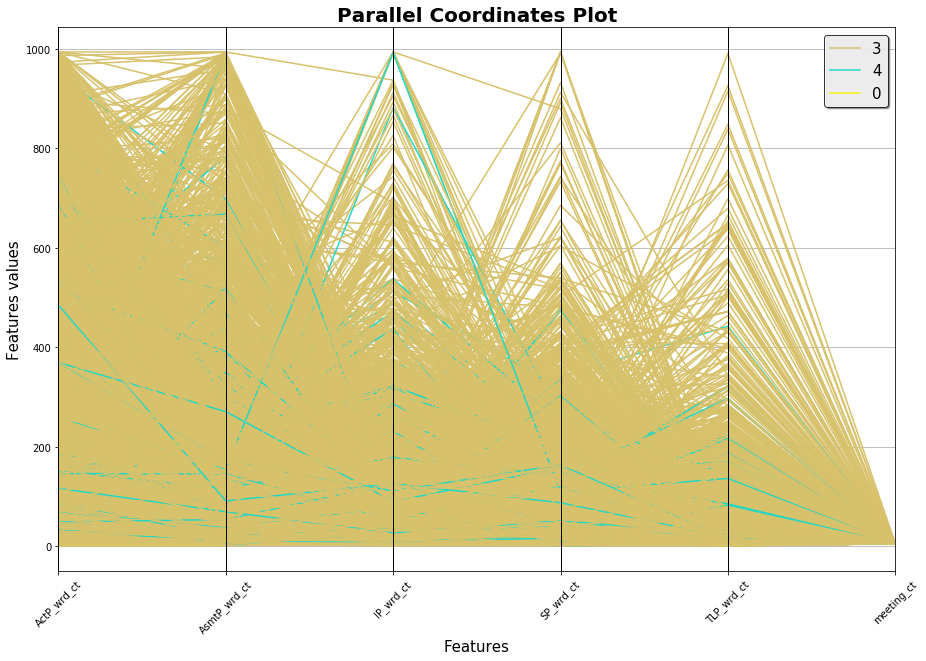

In [230]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(15,10))
parallel_coordinates(TIP_improved_vizes_length, "rating_to_predict")
plt.title('Parallel Coordinates Plot', fontsize=20, fontweight='bold')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features values', fontsize=15)
plt.xticks(rotation=45)
plt.legend(loc=1, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

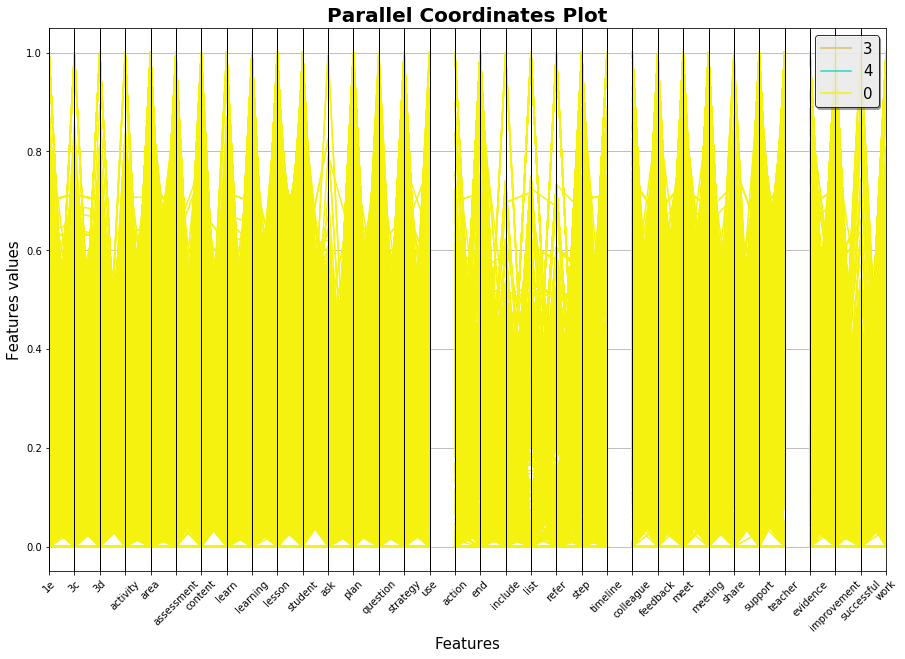

In [231]:
plt.figure(figsize=(15,10))
parallel_coordinates(TIP_improved_vizes_tfidf, "rating_to_predict")
plt.title('Parallel Coordinates Plot', fontsize=20, fontweight='bold')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features values', fontsize=15)
plt.xticks(rotation=45)
plt.legend(loc=1, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

In [68]:
plt.figure()
sns.pairplot(TIP_for_AP_improved, hue = "rating_to_predict", size=3)
plt.show()

ValueError: markers must be a singeton or a list of markers for each level of the hue variable

In [124]:
from pandas.plotting import radviz
data = TIP_for_AP_improved
plt.figure()
radviz(data, 'rating_to_predict')

TypeError: ("unsupported operand type(s) for -: 'str' and 'str'", 'occurred at index 1e')

In [123]:
plt.figure()
parallel_coordinates(TIP_for_AP_improved, 'rating_to_predict', colormap='gist_rainbow')

NameError: name 'parallel_coordinates' is not defined

PCA Viz

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

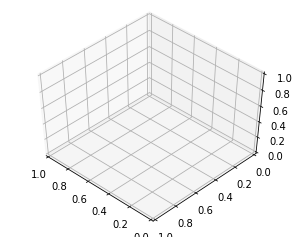

In [236]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
X = xvars
y = yvars

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('Effective', 3), ('Highly Effective', 4)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 3].mean() + 1.5,
              X[y == label, 4].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [3, 4]).astype(np.float)
ax.scatter(X[:, 3], X[:, 4], c=y, cmap=plt.cm.spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

In [237]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

NameError: name 'X_std' is not defined

In [ ]:
traces = []

for name in (3, 4):

    trace = Scatter(
        x=Y_sklearn[y==name,0],
        y=Y_sklearn[y==name,1],
        mode='markers',
        name=name,
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

C:\Users\egagne\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=5.0, right=5.0
  'left=%s, right=%s') % (left, right))
C:\Users\egagne\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=5.0, top=5.0
  'bottom=%s, top=%s') % (bottom, top))


LinAlgError: singular matrix

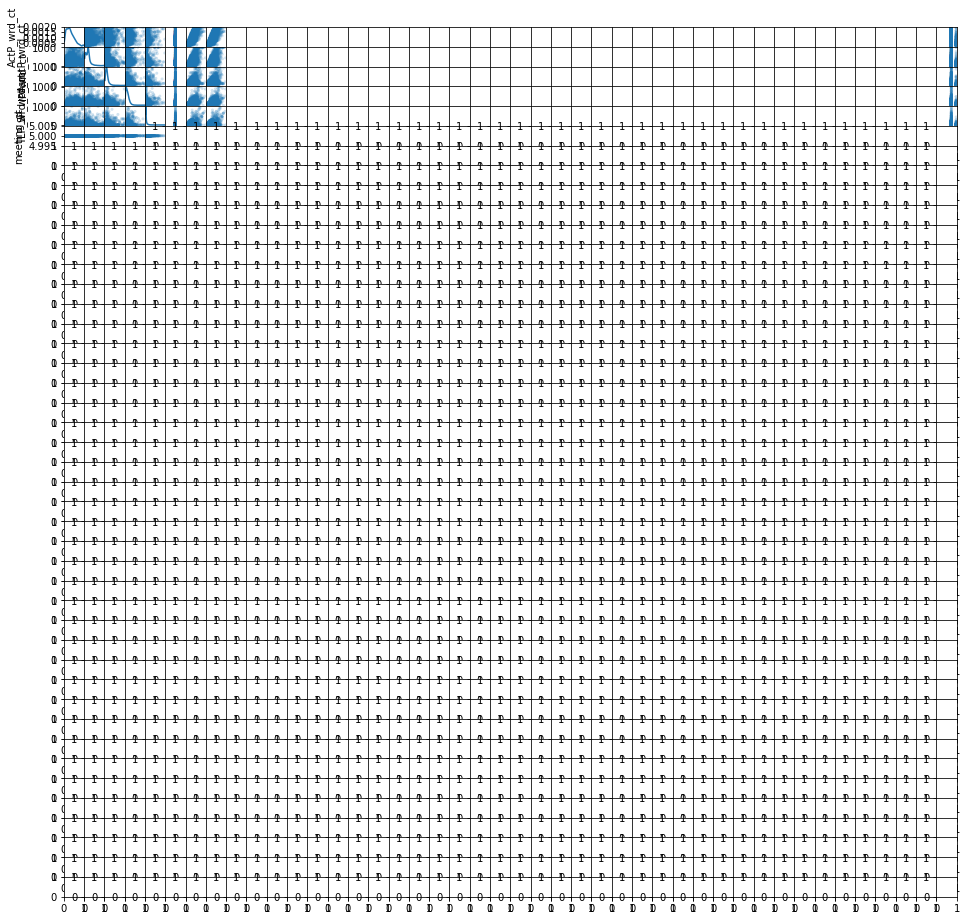

In [249]:
#from pandas.plotting import scatter_matrix

#now plot using pandas 
scatter_matrix(TIP_for_AP, alpha=0.2, figsize=(16, 16), diagonal='kde')

In [ ]:
from pandas.plotting import andrews_curves

andrews_curves(TIP_for_AP, 'rating_to_predict')